In [2]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import pycaret.regression as pyr
from sklearn.metrics import mean_absolute_error


In [3]:
df = pd.read_csv("consumption_temp.csv")
df['time'] = pd.to_datetime(df['time'])

df.describe()

,consumption,temperature
count,49494.000000,49494.000000
mean,3.509242,6.554019
std,3.096356,7.630308
min,0.000000,-17.299999
25%,1.263256,1.000000
50%,2.376530,6.800000
75%,5.189000,12.100000
max,18.045011,30.500000


In [4]:
import pandas as pd
import numpy as np

df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
#df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
#df['month'] = df['time'].dt.month


In [5]:
excluded_features_0_10 = ['time', 'temperature', 'original_location']
excluded_features_11_24 = ['time', 'temperature', 'original_location']

In [6]:

lags = [24, 25, 26, 48, 49, 50, 72]
delay = 120

for lag in lags:
    df[f'load_t-{lag}h'] = df.groupby('location')['consumption'].shift(lag+delay)
    df[f'temperature_t-{lag}h'] = df.groupby('location')['temperature'].shift(lag) 

    if lag < 48:
        excluded_features_11_24.append(f'load_t-{lag}h')
        excluded_features_11_24.append(f'temperature_t-{lag}h')
    

df.dropna(inplace=True)

In [7]:

df['original_location'] = df['location']
df = pd.get_dummies(df, columns=['location'])

In [8]:
from datetime import timedelta

def split_train_test_by_location(df, hour_limit=10):
    train_dfs = []
    test_dfs = []
    
    last_date = df['time'].max().date()
    test_start_date = last_date - timedelta(days=29)
    
    # Filter data based on hour
    if hour_limit == 10:
        df_filtered = df[df['hour'] <= 10].copy()
    else:
        df_filtered = df[df['hour'] > 10].copy()
    
    for location in df_filtered['original_location'].unique():
        location_data = df_filtered[df_filtered['original_location'] == location]
        
        # Split data based on time logic
        train_df = location_data[location_data['time'].dt.date < test_start_date]
        test_df = location_data[location_data['time'].dt.date >= test_start_date]
        
        train_dfs.append(train_df)
        test_dfs.append(test_df)
    
    # Combine the training data and testing data
    combined_train_df = pd.concat(train_dfs)
    combined_test_df = pd.concat(test_dfs)
    
    return combined_train_df, combined_test_df


In [9]:
def train_and_test_for_location(train_data, test_data, excluded_features):
    results = {}

    for location in train_data['original_location'].unique():
        location_train = train_data[train_data['original_location'] == location]
        location_test = test_data[test_data['original_location'] == location]


        pyr.setup(data=location_train, target='consumption', ignore_features=excluded_features,
                  fold_strategy='timeseries', session_id=42, data_split_shuffle=False, fold_shuffle=False)

        model = pyr.create_model('et')

        predictions = pyr.predict_model(model, data=location_test)

        results[location] = predictions

    return results


In [10]:
train_0_10, test_0_10 = split_train_test_by_location(df, hour_limit=10)
train_11_24, test_11_24 = split_train_test_by_location(df, hour_limit=11)

In [11]:
results_0_10 = train_and_test_for_location(train_0_10, test_0_10, excluded_features=excluded_features_0_10)
results_11_24 = train_and_test_for_location(train_11_24, test_11_24,excluded_features=excluded_features_11_24)

,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(3542, 26)"
4,Transformed data shape,"(3542, 23)"
5,Transformed train set shape,"(2479, 23)"
6,Transformed test set shape,"(1063, 23)"
7,Ignore features,3
8,Numeric features,22
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0675,0.0079,0.0890,0.1741,0.0523,0.1007
1,0.0732,0.0089,0.0941,0.1793,0.0544,0.0976
2,0.0727,0.0081,0.0898,0.2883,0.0543,0.1164
3,0.0872,0.0109,0.1042,0.0935,0.0602,0.1132
4,0.1044,0.0149,0.1222,-0.2128,0.0684,0.1260
5,0.0834,0.0105,0.1025,0.1494,0.0571,0.1007
6,0.1545,0.0332,0.1821,-0.7734,0.0969,0.1608
7,0.3844,0.2035,0.4511,-2.0071,0.2010,0.2639
8,0.1765,0.0445,0.2109,-0.1111,0.0786,0.1070


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.3671,0.2216,0.4707,-0.1511,0.1148,0.1135


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(3542, 26)"
4,Transformed data shape,"(3542, 23)"
5,Transformed train set shape,"(2479, 23)"
6,Transformed test set shape,"(1063, 23)"
7,Ignore features,3
8,Numeric features,22
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3584,0.1681,0.4100,-0.9835,0.1284,0.1794
1,0.1450,0.0359,0.1894,0.5722,0.0574,0.0630
2,0.1381,0.0323,0.1798,0.5813,0.0596,0.0714
3,0.0974,0.0141,0.1187,0.8080,0.0388,0.0479
4,0.2129,0.0594,0.2438,0.3946,0.0742,0.0901
5,0.3107,0.1584,0.3980,0.0142,0.1103,0.1129
6,0.5592,0.4610,0.6790,-1.3208,0.1700,0.1678
7,1.0327,1.4828,1.2177,-1.4784,0.2201,0.2031
8,0.6762,0.6965,0.8346,-0.3449,0.1150,0.1073


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.3466,2.8635,1.6922,-0.3456,0.1336,0.1106


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(3542, 26)"
4,Transformed data shape,"(3542, 23)"
5,Transformed train set shape,"(2479, 23)"
6,Transformed test set shape,"(1063, 23)"
7,Ignore features,3
8,Numeric features,22
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1366,0.0266,0.1629,-0.4871,0.0760,0.1283
1,0.1248,0.0242,0.1557,-0.0326,0.0691,0.0965
2,0.0868,0.0125,0.1120,0.5448,0.0517,0.0785
3,0.0769,0.0095,0.0975,0.6929,0.0447,0.0667
4,0.0808,0.0119,0.1093,0.6290,0.0473,0.0627
5,0.1138,0.0208,0.1443,0.3776,0.0620,0.0845
6,0.2310,0.0717,0.2677,-0.5349,0.1092,0.1483
7,0.7983,0.8023,0.8957,-3.4097,0.2947,0.3210
8,0.2783,0.1162,0.3409,-0.1379,0.0857,0.0954


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4582,0.3356,0.5793,0.2237,0.0889,0.0829


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(3542, 26)"
4,Transformed data shape,"(3542, 23)"
5,Transformed train set shape,"(2479, 23)"
6,Transformed test set shape,"(1063, 23)"
7,Ignore features,3
8,Numeric features,22
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0992,0.0167,0.1291,0.2654,0.0693,0.1223
1,0.0723,0.0080,0.0895,0.2668,0.0528,0.1093
2,0.0969,0.0136,0.1166,0.0581,0.0754,0.1980
3,0.0539,0.0044,0.0664,0.2594,0.0419,0.0892
4,0.0772,0.0090,0.0946,-0.0265,0.0570,0.1116
5,0.1237,0.0210,0.1448,-0.1427,0.0826,0.1542
6,0.0874,0.0099,0.0996,-0.4708,0.0537,0.0978
7,0.2151,0.0639,0.2527,-1.9221,0.1254,0.1877
8,0.1810,0.0490,0.2213,-1.4551,0.0932,0.1235


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1130,0.0196,0.1402,-0.0325,0.0478,0.0584


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(3542, 26)"
4,Transformed data shape,"(3542, 23)"
5,Transformed train set shape,"(2479, 23)"
6,Transformed test set shape,"(1063, 23)"
7,Ignore features,3
8,Numeric features,22
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2085,0.0645,0.2540,-0.4040,0.1156,0.1919
1,0.0991,0.0165,0.1286,0.3188,0.0610,0.0915
2,0.1627,0.0387,0.1967,-1.1765,0.1015,0.1957
3,0.0922,0.0125,0.1117,0.1486,0.0553,0.0870
4,0.0891,0.0124,0.1112,0.2616,0.0537,0.0813
5,0.1361,0.0265,0.1629,-0.2659,0.0766,0.1143
6,0.1822,0.0470,0.2168,-0.6754,0.0944,0.1304
7,0.3950,0.2128,0.4613,-1.3194,0.1755,0.2168
8,0.2036,0.0636,0.2522,-0.1709,0.0817,0.0983


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4663,0.3468,0.5889,-1.0492,0.1297,0.1232


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(2464, 26)"
4,Transformed data shape,"(2464, 23)"
5,Transformed train set shape,"(1724, 23)"
6,Transformed test set shape,"(740, 23)"
7,Ignore features,3
8,Numeric features,22
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2714,0.1074,0.3277,-1.5999,0.0519,0.0498
1,0.3655,0.1813,0.4258,-25.9750,0.0651,0.0630
2,0.3680,0.2446,0.4946,-0.8693,0.0675,0.0573
3,0.1671,0.0489,0.2211,-1.8144,0.0310,0.0269
4,0.1485,0.0335,0.1830,-0.2377,0.0255,0.0236
5,0.0941,0.0127,0.1129,-2.7064,0.0155,0.0151
6,0.0513,0.0142,0.1190,-0.1909,0.0171,0.0085
7,0.1143,0.0178,0.1335,-2.9552,0.0182,0.0178
8,0.1112,0.0203,0.1425,-0.4446,0.0191,0.0170


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1881,0.0620,0.2490,-2.5012,0.0342,0.0302


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(4189, 26)"
4,Transformed data shape,"(4189, 17)"
5,Transformed train set shape,"(2932, 17)"
6,Transformed test set shape,"(1257, 17)"
7,Ignore features,9
8,Numeric features,16
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0633,0.0063,0.0793,0.3266,0.0446,0.0809
1,0.1003,0.0168,0.1295,-0.4004,0.0701,0.1121
2,0.0886,0.0115,0.1071,0.1546,0.0588,0.1067
3,0.1049,0.0162,0.1273,-0.4066,0.0675,0.1117
4,0.1431,0.0273,0.1652,-0.9067,0.0849,0.1408
5,0.1031,0.0157,0.1253,0.0243,0.0643,0.1025
6,0.1900,0.0533,0.2309,-1.0155,0.1112,0.1618
7,0.3868,0.2108,0.4592,-0.8964,0.1812,0.2210
8,0.1547,0.0371,0.1925,0.3336,0.0644,0.0776


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4113,0.2565,0.5064,-0.2344,0.1166,0.1175


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(4189, 26)"
4,Transformed data shape,"(4189, 17)"
5,Transformed train set shape,"(2932, 17)"
6,Transformed test set shape,"(1257, 17)"
7,Ignore features,9
8,Numeric features,16
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2398,0.0810,0.2845,-0.0531,0.0829,0.1034
1,0.2192,0.0680,0.2608,0.2464,0.0711,0.0794
2,0.1057,0.0188,0.1371,0.7599,0.0386,0.0422
3,0.1107,0.0183,0.1353,0.6469,0.0380,0.0442
4,0.3555,0.1725,0.4153,-0.1075,0.1051,0.1155
5,0.2886,0.1677,0.4095,0.1783,0.0976,0.0846
6,0.6804,0.6921,0.8319,-1.5237,0.1822,0.1704
7,1.0654,1.6282,1.2760,-0.8328,0.2012,0.1805
8,0.7372,0.7682,0.8765,0.0125,0.1076,0.0998


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.9869,1.4559,1.2066,0.1717,0.0929,0.0806


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(4189, 26)"
4,Transformed data shape,"(4189, 17)"
5,Transformed train set shape,"(2932, 17)"
6,Transformed test set shape,"(1257, 17)"
7,Ignore features,9
8,Numeric features,16
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0978,0.0152,0.1233,0.1895,0.0546,0.0800
1,0.1821,0.0451,0.2123,-0.8634,0.0873,0.1197
2,0.0928,0.0135,0.1160,0.5110,0.0470,0.0638
3,0.0827,0.0121,0.1098,0.5111,0.0445,0.0573
4,0.1125,0.0192,0.1386,0.4057,0.0542,0.0705
5,0.1241,0.0236,0.1535,0.3668,0.0591,0.0766
6,0.2865,0.1189,0.3449,-1.0928,0.1261,0.1519
7,0.7971,0.8247,0.9081,-2.0183,0.2573,0.2709
8,0.3319,0.1583,0.3979,0.0097,0.0886,0.0931


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4066,0.2432,0.4932,0.3684,0.0744,0.0723


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(4189, 26)"
4,Transformed data shape,"(4189, 17)"
5,Transformed train set shape,"(2932, 17)"
6,Transformed test set shape,"(1257, 17)"
7,Ignore features,9
8,Numeric features,16
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1148,0.0188,0.1371,0.2101,0.0704,0.1255
1,0.0863,0.0110,0.1049,0.1348,0.0580,0.1093
2,0.1045,0.0169,0.1301,-0.1236,0.0767,0.1675
3,0.0896,0.0114,0.1070,-0.8287,0.0623,0.1231
4,0.0904,0.0116,0.1079,-0.1606,0.0603,0.1112
5,0.1380,0.0252,0.1586,-0.3343,0.0842,0.1478
6,0.0864,0.0111,0.1055,-0.0851,0.0531,0.0840
7,0.2249,0.0636,0.2523,-0.9798,0.1157,0.1747
8,0.1866,0.0467,0.2160,-1.1175,0.0846,0.1135


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1601,0.0388,0.1971,-0.1397,0.0662,0.0842


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(4189, 26)"
4,Transformed data shape,"(4189, 17)"
5,Transformed train set shape,"(2932, 17)"
6,Transformed test set shape,"(1257, 17)"
7,Ignore features,9
8,Numeric features,16
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1891,0.0516,0.2272,-0.1794,0.0958,0.1449
1,0.1278,0.0265,0.1627,0.0763,0.0705,0.1041
2,0.1672,0.0411,0.2028,-0.7771,0.0937,0.1589
3,0.1128,0.0198,0.1408,-0.1312,0.0627,0.0901
4,0.1062,0.0166,0.1289,0.2208,0.0569,0.0829
5,0.1576,0.0355,0.1884,-0.0902,0.0793,0.1089
6,0.2324,0.0692,0.2631,-0.4080,0.1033,0.1400
7,0.4587,0.2923,0.5406,-1.4222,0.1879,0.2148
8,0.1693,0.0409,0.2022,0.4996,0.0601,0.0703


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4190,0.2795,0.5287,-0.2018,0.1103,0.1062


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(2915, 26)"
4,Transformed data shape,"(2915, 17)"
5,Transformed train set shape,"(2040, 17)"
6,Transformed test set shape,"(875, 17)"
7,Ignore features,9
8,Numeric features,16
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3115,0.1533,0.3915,-1.8177,0.0621,0.0566
1,0.2812,0.1346,0.3669,-11.8044,0.0557,0.0482
2,0.2937,0.1206,0.3473,-1.0987,0.0485,0.0469
3,0.1610,0.0495,0.2225,-2.2196,0.0307,0.0256
4,0.1328,0.0247,0.1572,-0.3113,0.0216,0.0209
5,0.0955,0.0126,0.1124,-2.1614,0.0153,0.0152
6,0.0631,0.0144,0.1200,-0.2763,0.0171,0.0103
7,0.1463,0.0272,0.1650,-4.4191,0.0224,0.0227
8,0.2399,0.0688,0.2624,-2.9277,0.0350,0.0362


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1518,0.0497,0.2229,-1.8378,0.0308,0.0243


In [12]:
pyr.setup(data=train_0_10, target='consumption', ignore_features=excluded_features_0_10, fold_strategy='timeseries', session_id=42, data_split_shuffle=False, fold_shuffle=False)
best_model_0_10 = pyr.create_model('et')
predictions_0_10 = pyr.predict_model(best_model_0_10, data=test_0_10)

,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(20174, 26)"
4,Transformed data shape,"(20174, 23)"
5,Transformed train set shape,"(14121, 23)"
6,Transformed test set shape,"(6053, 23)"
7,Ignore features,3
8,Numeric features,22
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6663,0.8150,0.9028,-0.8744,0.3645,0.3688
1,0.3375,0.1706,0.4130,0.2018,0.1073,0.1125
2,0.2157,0.0796,0.2822,0.4229,0.0835,0.0951
3,4.9958,37.7810,6.1466,-1.7295,0.8517,0.5516
4,0.6774,0.8808,0.9385,0.9709,0.1295,0.1776
5,0.1741,0.0724,0.2691,0.1817,0.1051,0.1134
6,1.2025,2.4443,1.5634,-0.1381,0.2141,0.2346
7,0.2154,0.1048,0.3237,0.9750,0.0919,0.1660
8,0.1385,0.0301,0.1734,0.6457,0.0870,0.1452


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.6443,0.8010,0.8950,0.9212,0.1238,0.1262


In [13]:
pyr.setup(data=train_11_24, target='consumption', ignore_features=excluded_features_11_24, fold_strategy='timeseries', session_id=42, data_split_shuffle=False, fold_shuffle=False)
best_model_11_24 = pyr.create_model('et')
predictions_11_24 = pyr.predict_model(best_model_11_24, data=test_11_24)

,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(23860, 26)"
4,Transformed data shape,"(23860, 17)"
5,Transformed train set shape,"(16702, 17)"
6,Transformed test set shape,"(7158, 17)"
7,Ignore features,9
8,Numeric features,16
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8415,1.2446,1.1156,-1.2222,0.4215,0.3965
1,0.4053,0.2459,0.4959,0.1878,0.1150,0.1173
2,0.3047,0.1839,0.4288,0.0275,0.1093,0.1028
3,5.8180,50.1420,7.0811,-2.1499,0.9160,0.5646
4,0.8451,1.4626,1.2094,0.9595,0.1308,0.1706
5,0.2424,0.1278,0.3575,-0.1523,0.1281,0.1315
6,1.1775,2.5620,1.6006,-0.1106,0.2027,0.2066
7,0.2439,0.1162,0.3408,0.9763,0.1019,0.1811
8,0.1519,0.0365,0.1911,0.6317,0.0891,0.1412


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.7305,1.0394,1.0195,0.9047,0.1322,0.1353


In [14]:
def calculate_mape(true_values, predicted_values):
    return np.mean(np.abs((true_values - predicted_values) / true_values)) * 100


In [15]:
# Calculate MAPE for training on the entire dataset (for hours 0-10 and 11-24)
# Combine test data and predictions for both hour ranges
combined_test = pd.concat([test_0_10, test_11_24])
combined_predictions_entire = pd.concat([predictions_0_10, predictions_11_24])

# Calculate MAPE for training on the entire dataset for each location
mape_entire_by_location = {}
for location in combined_test['original_location'].unique():
    true_values = combined_test[combined_test['original_location'] == location]['consumption']
    predicted_values = combined_predictions_entire[combined_predictions_entire['original_location'] == location]['prediction_label']
    mape_entire_by_location[location] = calculate_mape(true_values, predicted_values)

# Calculate total MAPE for training on individual locations for each location
mape_individual_by_location = {}
for location in combined_test['original_location'].unique():
    true_values_0_10 = results_0_10[location]['consumption']
    predicted_values_0_10 = results_0_10[location]['prediction_label']
    true_values_11_24 = results_11_24[location]['consumption']
    predicted_values_11_24 = results_11_24[location]['prediction_label']
    
    combined_true = pd.concat([true_values_0_10, true_values_11_24])
    combined_predicted = pd.concat([predicted_values_0_10, predicted_values_11_24])
    
    mape_individual_by_location[location] = calculate_mape(combined_true, combined_predicted)

# Print MAPE values
print("MAPE for training on entire dataset by location:")
for location, mape in mape_entire_by_location.items():
    print(f"{location}: {mape:.2f}%")

print("\nMAPE for training on individual locations by location:")
for location, mape in mape_individual_by_location.items():
    print(f"{location}: {mape:.2f}%")

# Calculate and print MAPE for the entire dataset for both training methods
mape_entire_total = calculate_mape(combined_test['consumption'], combined_predictions_entire['prediction_label'])
combined_true_individual = pd.concat([results_0_10[loc]['consumption'] for loc in results_0_10.keys()] + [results_11_24[loc]['consumption'] for loc in results_11_24.keys()])
combined_predicted_individual = pd.concat([results_0_10[loc]['prediction_label'] for loc in results_0_10.keys()] + [results_11_24[loc]['prediction_label'] for loc in results_11_24.keys()])
mape_individual_total = calculate_mape(combined_true_individual, combined_predicted_individual)

print("\nMAPE for the entire dataset:")
print(f"Training on entire dataset: {mape_entire_total:.2f}%")
print(f"Training on individual locations: {mape_individual_total:.2f}%")


MAPE for training on entire dataset by location:
bergen: 9.52%
oslo: 9.75%
stavanger: 9.00%
tromsø: 6.98%
trondheim: 20.86%
helsingfors: 22.55%

MAPE for training on individual locations by location:
bergen: 11.56%
oslo: 9.44%
stavanger: 7.72%
tromsø: 7.23%
trondheim: 11.40%
helsingfors: 2.70%

MAPE for the entire dataset:
Training on entire dataset: 13.11%
Training on individual locations: 8.34%


In [16]:
import plotly.graph_objects as go

combined_individual_predictions = {}
for location in results_0_10.keys():
    combined_df = pd.concat([results_0_10[location], results_11_24[location]])
    combined_df = combined_df.sort_values(by='time')
    combined_individual_predictions[location] = combined_df

# Plot the results for each location
for location, subset_df in combined_individual_predictions.items():

    
    time = subset_df['time']
    true_values = subset_df['consumption']
    predicted_values = subset_df['prediction_label']
    errors = true_values - predicted_values
    absolute_percentage_errors = (np.abs(true_values - predicted_values) / true_values) * 100

    fig = go.Figure()

    # Add traces for true values, predicted values, and absolute percentage errors
    fig.add_trace(go.Scatter(x=time, y=true_values, mode='lines', name='True Values'))
    fig.add_trace(go.Scatter(x=time, y=predicted_values, mode='lines', name='Predicted Values'))

    # Update layout for better visualization
    fig.update_layout(
        title=f'Predicted and True Values over Time for {location}',
        xaxis_title='Time',
        yaxis_title='Values',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            type="date"
        ),
        showlegend=True
    )

    fig.show()

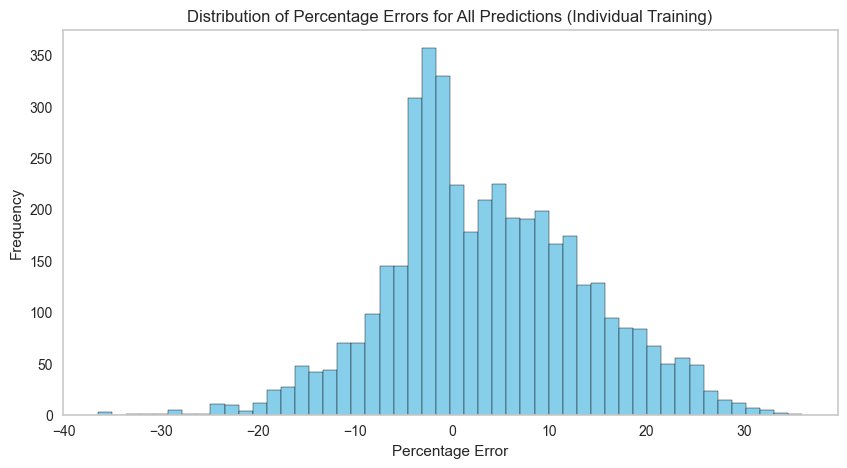

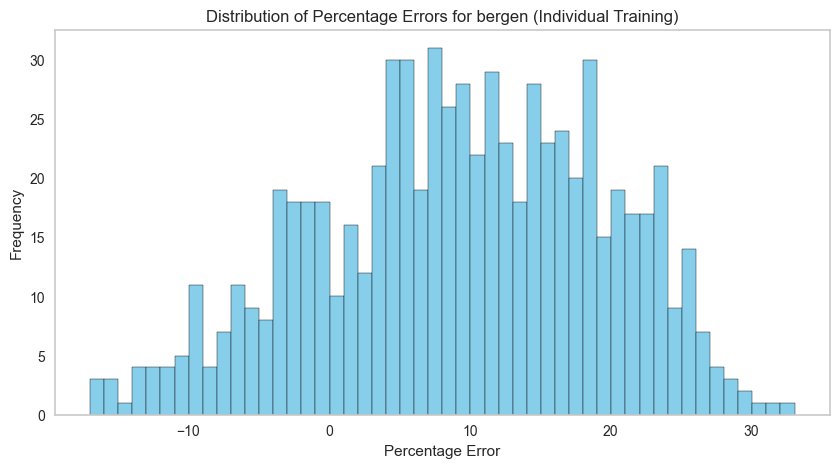

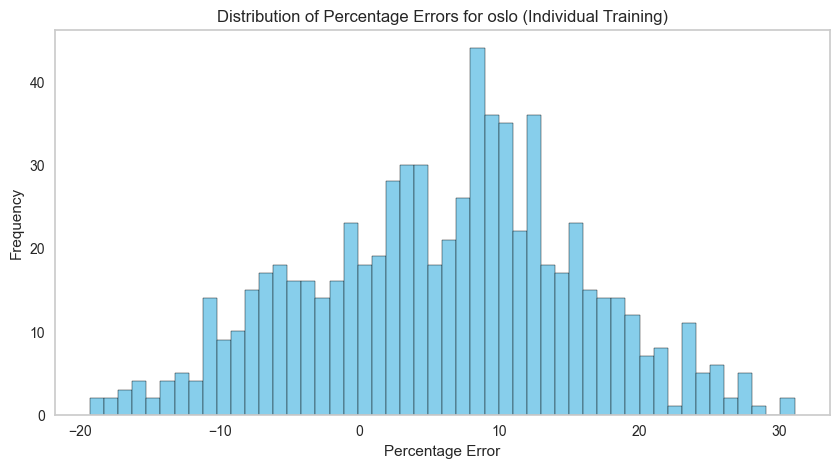

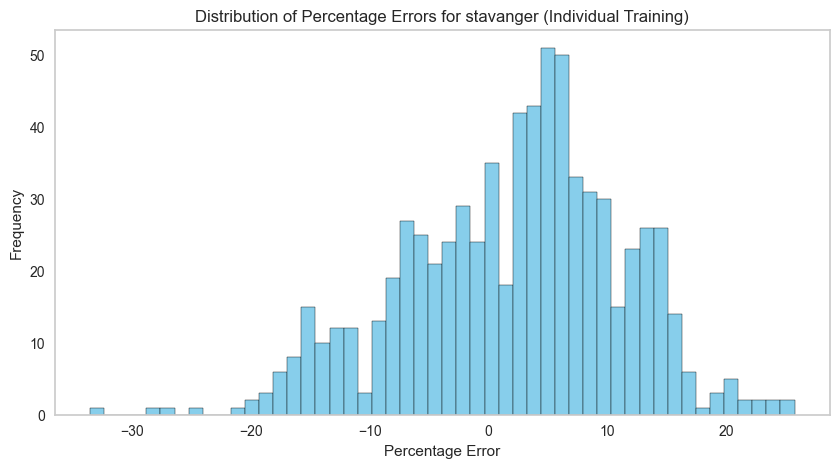

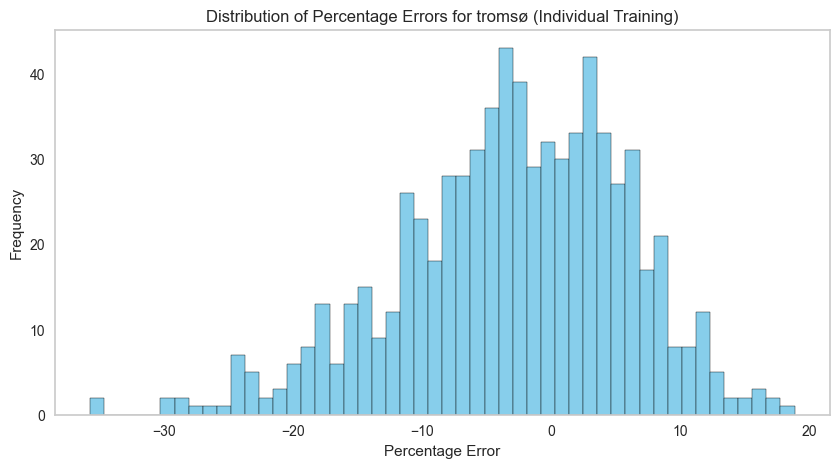

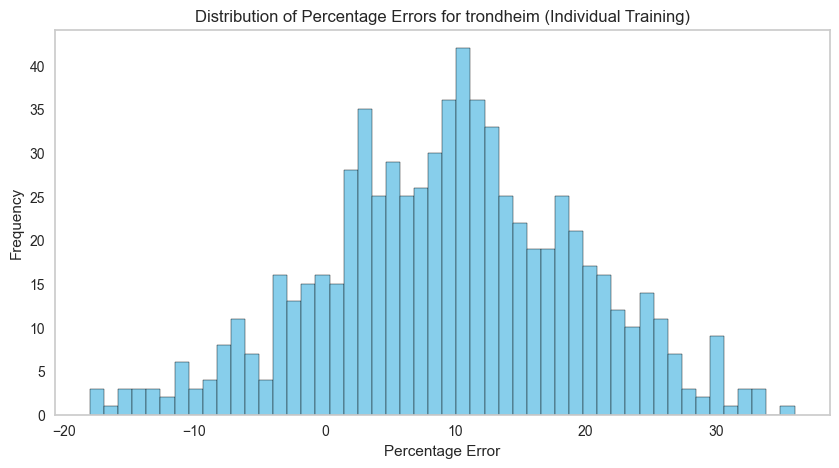

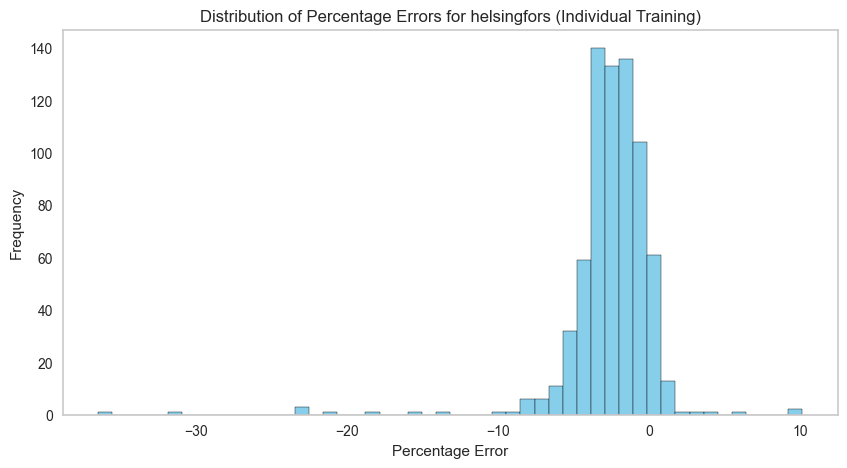

In [17]:
import matplotlib.pyplot as plt

# Function to calculate percentage errors
def calculate_percentage_errors(true_values, predicted_values):
    return ((true_values - predicted_values) / true_values) * 100

# Calculate percentage errors for all predictions combined
all_percentage_errors_individual = []
for location in combined_test['original_location'].unique():
    true_values_0_10 = results_0_10[location]['consumption']
    predicted_values_0_10 = results_0_10[location]['prediction_label']
    true_values_11_24 = results_11_24[location]['consumption']
    predicted_values_11_24 = results_11_24[location]['prediction_label']
    
    combined_true = pd.concat([true_values_0_10, true_values_11_24])
    combined_predicted = pd.concat([predicted_values_0_10, predicted_values_11_24])
    
    percentage_errors = calculate_percentage_errors(combined_true, combined_predicted)
    all_percentage_errors_individual.extend(percentage_errors)

# Plot histogram of percentage errors for all predictions combined
plt.figure(figsize=(10, 5))
plt.hist(all_percentage_errors_individual, bins=50, edgecolor='black', color='skyblue')
plt.title('Distribution of Percentage Errors for All Predictions (Individual Training)')
plt.xlabel('Percentage Error')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# Plot histogram of percentage errors for each location
for location in combined_test['original_location'].unique():
    true_values_0_10 = results_0_10[location]['consumption']
    predicted_values_0_10 = results_0_10[location]['prediction_label']
    true_values_11_24 = results_11_24[location]['consumption']
    predicted_values_11_24 = results_11_24[location]['prediction_label']
    
    combined_true = pd.concat([true_values_0_10, true_values_11_24])
    combined_predicted = pd.concat([predicted_values_0_10, predicted_values_11_24])
    
    percentage_errors = calculate_percentage_errors(combined_true, combined_predicted)
    
    plt.figure(figsize=(10, 5))
    plt.hist(percentage_errors, bins=50, edgecolor='black', color='skyblue')
    plt.title(f'Distribution of Percentage Errors for {location} (Individual Training)')
    plt.xlabel('Percentage Error')
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()


In [18]:
import seaborn as sns
import plotly.graph_objects as go

def calculate_percentage_errors(true_values, predicted_values):
    return ((true_values - predicted_values) / true_values) * 100

# Dictionary to store the percentage errors for each location
percentage_errors_per_location = {}

# For each location, calculate percentage errors and store them
for location in combined_test['original_location'].unique():
    true_values_0_10 = results_0_10[location]['consumption']
    predicted_values_0_10 = results_0_10[location]['prediction_label']
    true_values_11_24 = results_11_24[location]['consumption']
    predicted_values_11_24 = results_11_24[location]['prediction_label']
    
    combined_true = pd.concat([true_values_0_10, true_values_11_24])
    combined_predicted = pd.concat([predicted_values_0_10, predicted_values_11_24])
    
    percentage_errors = calculate_percentage_errors(combined_true, combined_predicted)
    percentage_errors_per_location[location] = percentage_errors

# Create a DataFrame from the dictionary
#location_errors_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in percentage_errors_per_location.items()]))

location_errors_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in percentage_errors_per_location.items()]))

box_plots = [
    go.Box(
        y=location_errors_df[location].dropna(),  # Drop NaN values for plotting
        name=location,
        boxpoints='all',  # Display all points
        jitter=0.3,  # Spread out points for better visibility
        whiskerwidth=0.2,
        marker_size=3,
        line_width=2,
        
    )
    for location in location_errors_df.columns
]

# Create a figure with the box plots
fig = go.Figure(data=box_plots)

# Update layout for a prettier look
fig.update_layout(
    title='Box Plot of Percentage Errors for Each Location',
    xaxis=dict(title='Location', tickangle=-45),  # Rotate location labels for better readability
    yaxis=dict(title='Percentage Error'),
    showlegend=False,  # Hide the legend if not required
    plot_bgcolor='white',  # Set background to white for a clean look
    margin=dict(l=40, r=40, t=40, b=40),  # Set margins to avoid clipping
    height=600,
    width=900
)

# Update axes lines
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='lightgray')

# Show the figure
fig.show()




'''
# Define a color palettesd
palette = sns.color_palette("Set3")  # You can choose other palettes like "Set1", "Set3", "muted", etc.

# Plot box plot
plt.figure(figsize=(15, 8))
location_errors_df.boxplot()
plt.title('Box Plot of Percentage Errors for Each Location')
plt.xlabel('Location')
plt.ylabel('Percentage Error')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
'''

'\n# Define a color palettesd\npalette = sns.color_palette("Set3")  # You can choose other palettes like "Set1", "Set3", "muted", etc.\n\n# Plot box plot\nplt.figure(figsize=(15, 8))\nlocation_errors_df.boxplot()\nplt.title(\'Box Plot of Percentage Errors for Each Location\')\nplt.xlabel(\'Location\')\nplt.ylabel(\'Percentage Error\')\nplt.xticks(rotation=45)\nplt.grid(True)\nplt.show()\n'

In [19]:
print(box_plots)

[Box({
    'boxpoints': 'all',
    'jitter': 0.3,
    'line': {'width': 2},
    'marker': {'size': 3},
    'name': 'bergen',
    'whiskerwidth': 0.2,
    'y': array([ 7.42014059,  4.71963591,  4.16441105, ..., 12.31998032,  5.61303105,
                -0.64291367])
}), Box({
    'boxpoints': 'all',
    'jitter': 0.3,
    'line': {'width': 2},
    'marker': {'size': 3},
    'name': 'oslo',
    'whiskerwidth': 0.2,
    'y': array([5.29174046, 3.52523536, 2.71199531, ..., 5.9235953 , 3.10802033,
                2.093667  ])
}), Box({
    'boxpoints': 'all',
    'jitter': 0.3,
    'line': {'width': 2},
    'marker': {'size': 3},
    'name': 'stavanger',
    'whiskerwidth': 0.2,
    'y': array([ 0.60987352, -0.87083799, -2.53075636, ...,  6.63782532,  2.29438331,
                -4.47983448])
}), Box({
    'boxpoints': 'all',
    'jitter': 0.3,
    'line': {'width': 2},
    'marker': {'size': 3},
    'name': 'tromsø',
    'whiskerwidth': 0.2,
    'y': array([12.03698799,  6.28240447,  5.700

In [20]:
fig = go.Figure()

# Add a few traces without specifying a color
for i in range(5):
    fig.add_trace(go.Scatter(y=[i, i+1, i+2], mode='lines', name=f'Trace {i}'))

# Show the figure
fig.show()